In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPool1D, BatchNormalization
from pathlib import Path
from tensorflow.keras.regularizers import l2
import datetime
import shutil

In [4]:
!mkdir kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d ma7555/cat-breeds-dataset

100% 1.93G/1.93G [00:18<00:00, 47.8MB/s]
100% 1.93G/1.93G [00:18<00:00, 110MB/s] 


In [9]:
! mkdir cat_breed_data

In [10]:
! unzip cat-breeds-dataset.zip -d cat_breed_data

Streaming output truncated to the last 5000 lines.
  inflating: cat_breed_data/images/Tortoiseshell/46495717_25061.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46495784_25049.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46495794_25052.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46496797_24946.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46497000_24936.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46497664_24825.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46500078_24567.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46504471_24003.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46507777_23590.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46510043_23381.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46510643_23331.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46512081_23194.jpg  
  inflating: cat_breed_data/images/Tortoiseshell/46513326_23056.jpg  
  inflating: cat_breed_data/images/Tort

In [11]:
! mkdir data
! mkdir data/Train
! mkdir data/Test

In [12]:
# creating folders as our required datasets for Both training and Test Dataset

cat_breed = ['Bombay', 'Calico', 'Burmese', 'Himalayan', 'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 'Dilute Calico']
path = "/content/data/Train/"
for i in cat_breed:
  os.mkdir(path+i)
path2 = "/content/data/Test/"
for i in cat_breed:
  os.mkdir(path2+i)

In [13]:
cat_breed = ['Bombay', 'Calico', 'Burmese', 'Himalayan', 'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 'Dilute Calico']

# here spliting dataset into 80:20 and copying it into the respective folders.
for folder in cat_breed:
  source_dir = '/content/cat_breed_data/images/' + folder 
  target_dir_train = '/content/data/Train/' + folder 
  target_dir_test = '/content/data/Test/' + folder 

  file_names = os.listdir(source_dir)

  for file_name in file_names:
    if np.random.rand(1) < 0.2:
      shutil.copy(os.path.join(source_dir, file_name), target_dir_test)
    else:
      shutil.copy(os.path.join(source_dir, file_name), target_dir_train)

In [25]:
# getting our data counts here
number = []
for folder in cat_breed:
   num = len(os.listdir('/content/data/Train/' + folder ))
   number.append(num)

[1499, 2764, 267, 1037, 147, 2108, 154, 468, 1487, 2601]

Number of images that are Bombay Breed 1499 , ( (11.961378870092563, '%)')
Number of images that are Calico Breed 2764 , ( (22.055537823172678, '%)')
Number of images that are Burmese Breed 267 , ( (2.130545802744973, '%)')
Number of images that are Himalayan Breed 1037 , ( (8.274816469837216, '%)')
Number of images that are Muchkin Breed 147 , ( (1.1729971273539739, '%)')
Number of images that are Ragdoll Breed 2108 , ( (16.820938397701884, '%)')
Number of images that are Siberian Breed 154 , ( (1.2288541334184488, '%)')
Number of images that are British Shorthair Breed 468 , ( (3.7344398340248963, '%)')
Number of images that are Russian Blue Breed 1487 , ( (11.865624002553462, '%)')
Number of images that are Dilute Calico Breed 2601 , ( (20.754867539099905, '%)')


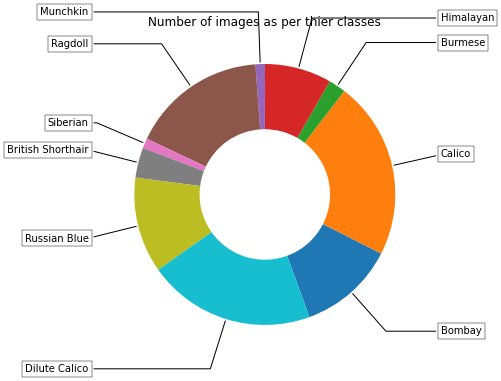

In [35]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html
#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


print("Number of images that are Bombay Breed", number[0], ", (", (number[0]/(sum(number))*100,"%)"))
print("Number of images that are Calico Breed", number[1], ", (", (number[1]/(sum(number))*100,"%)"))
print("Number of images that are Burmese Breed", number[2], ", (", (number[2]/(sum(number))*100,"%)"))
print("Number of images that are Himalayan Breed", number[3], ", (", (number[3]/(sum(number))*100,"%)"))
print("Number of images that are Muchkin Breed", number[4], ", (", (number[4]/(sum(number))*100,"%)"))
print("Number of images that are Ragdoll Breed", number[5], ", (", (number[5]/(sum(number))*100,"%)"))
print("Number of images that are Siberian Breed", number[6], ", (", (number[6]/(sum(number))*100,"%)"))
print("Number of images that are British Shorthair Breed", number[7], ", (", (number[7]/(sum(number))*100,"%)"))
print("Number of images that are Russian Blue Breed", number[8], ", (", (number[8]/(sum(number))*100,"%)"))
print("Number of images that are Dilute Calico Breed", number[9], ", (", (number[9]/(sum(number))*100,"%)"))


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ['Bombay', 'Calico', 'Burmese', 'Himalayan', 'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 'Dilute Calico']

data = [1499, 2764, 267, 1037, 147, 2108, 154, 468, 1487, 2601]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-70)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.45)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of images as per thier classes")

plt.show()

#### Munchkin, Siberian, British Shorthair and Burmese are less in number 1 to 2 percentage in overall all dataset causes data imbalancement problem.


In [14]:
# Imagedatagenerator for image augumentation
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=20, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2,
                                     shear_range=0.2, 
                                     zoom_range=0.2,
                                     ) # inception preprocessing

test_generator = ImageDataGenerator(rescale=1./255) # inception preprocessing


In [15]:
train_data_dir = "/content/data/Train"
test_data_dir = "/content/data/Test"

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(299,299),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=64, 
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             batch_size=64,
                                             shuffle=False,
                                             seed=42)

Found 12532 images belonging to 10 classes.
Found 3122 images belonging to 10 classes.


In [16]:
def create_model(input_shape, n_classes, fine_tune=0):
    """
    Compiles a model integrated with InceptionV3 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = InceptionV3(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output

    conv_layer_1 = Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(top_model)
    Pool_1 = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(conv_layer_1)
    batch_norm_1 = BatchNormalization()(Pool_1)

    conv_layer_2 = Conv2D(filters=128,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(batch_norm_1)
    Pool_2 = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='same')(conv_layer_2)
    batch_norm_2 = BatchNormalization()(Pool_2)

    flatten = Flatten()(batch_norm_2)

    FC_1 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(flatten)
    batch_norm_4 = BatchNormalization()(FC_1)

    FC_2 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(),kernel_regularizer=l2(0.001))(batch_norm_4)

    dropout = Dropout(0.7)(FC_2)
    output_layer = Dense(10, activation='softmax', kernel_initializer=tf.keras.initializers.he_normal(), kernel_regularizer=l2(0.001))(dropout)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optim, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy','AUC'])
    model.summary()
    
    return model

In [17]:
!pip install git+git://github.com/stared/livelossplot.git --upgrade --quiet

In [18]:
tf.keras.backend.clear_session()
input_shape = (299, 299, 3)
optim = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // 64
#n_val_steps = validgen.samples // 64
n_epochs = 100


incp_model = create_model(input_shape, n_classes, fine_tune=0)

87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [19]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10, min_delta=0.005,
                           restore_best_weights=True,
                           mode='min')

#reducing learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2)

#termination on NaN callback
terminate = TerminateOnNaN()

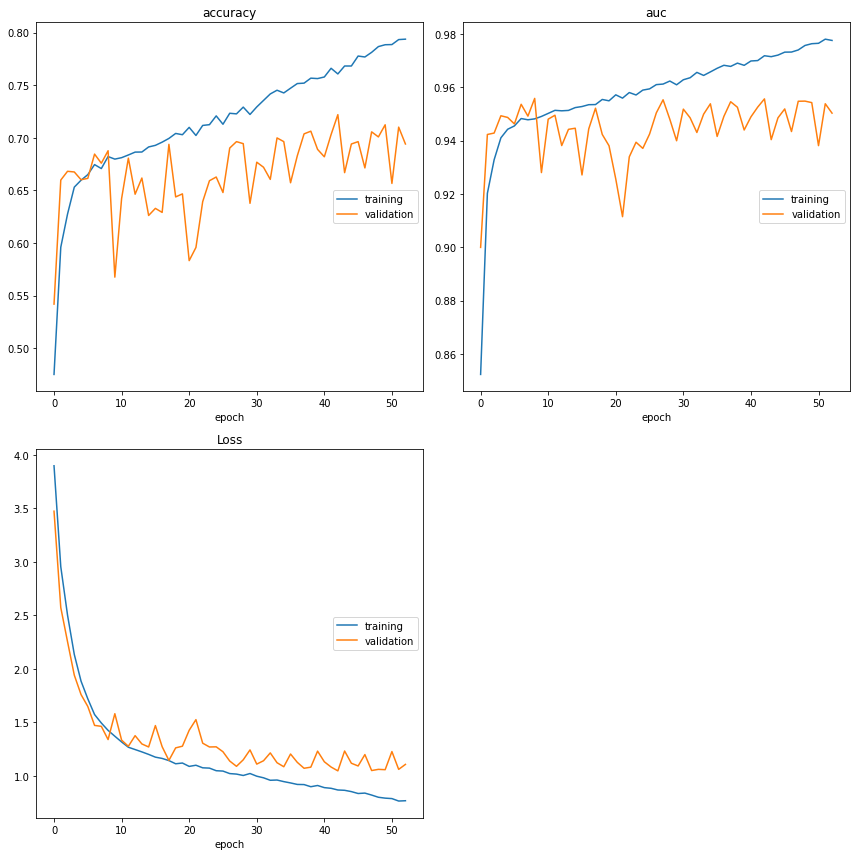

accuracy
	training         	 (min:    0.475, max:    0.794, cur:    0.794)
	validation       	 (min:    0.542, max:    0.722, cur:    0.694)
auc
	training         	 (min:    0.852, max:    0.978, cur:    0.978)
	validation       	 (min:    0.900, max:    0.956, cur:    0.950)
Loss
	training         	 (min:    0.763, max:    3.899, cur:    0.766)
	validation       	 (min:    1.046, max:    3.474, cur:    1.106)
CPU times: user 3h 51min 18s, sys: 4min 9s, total: 3h 55min 27s
Wall time: 3h 42min 19s


In [20]:
%%time
incp_model.fit(traingen,epochs=n_epochs,validation_data=testgen,steps_per_epoch=n_steps,\
               callbacks=[tl_checkpoint_1, early_stop, plot_loss_1, reduce_lr, terminate],
                            verbose=1)

In [22]:
eval = incp_model.evaluate(testgen)

print('{} is the loss of model, {} is the accuracy of the model and {} is the AUC score of our model'.format(eval[0], eval[1], eval[2]))

49/49 [==============================] - 14s 280ms/step - loss: 1.0457 - accuracy: 0.7220 - auc: 0.9556
1.0456732511520386 is the loss of model, 0.7219731211662292 is the accuracy of the model and 0.9556328058242798 is the AUC score of our model
